<a href="https://colab.research.google.com/github/chinu1997/Capstone-4-Team-3-/blob/main/Chinmaya_Devprasad_of_Topic_Modeling_on_News_Articles_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

## <b> Data Description </b>

### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 11.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=3f9e966bccd1d9bedf784b571c93d55ce2d1f738049694d5bd3cdb32df77e78d
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
News=[]
Type=[]
path="/content/drive/MyDrive/Almabetter/Cohort Aravali/Module 4/Capstone-4/Topic Modeling on BBC News Articles/bbc"
folders=["business","entertainment","politics","sport","tech"] 
for i in folders:
    files=os.listdir(path+'/'+i)
    for text_file in files:
        file_path=path + '/'+i+'/'+text_file
        with open(file_path,'rb') as f:
            data=f.read()
        News.append(data)
        Type.append(i)

data={'news':News,'type':Type}
df = pd.DataFrame(data)

In [ ]:
df.head()

,news,type
0,b'Mixed signals from French economy\n\nThe Fre...,business
1,b'US trade gap hits record in 2004\n\nThe gap ...,business
2,b'Indonesians face fuel price rise\n\nIndonesi...,business
3,b'High fuel prices hit BA\'s profits\n\nBritis...,business
4,b'Sluggish economy hits German jobs\n\nThe num...,business


In [ ]:
df.shape

(2225, 2)

Text(0.5, 1.0, 'Type Of news Counts')

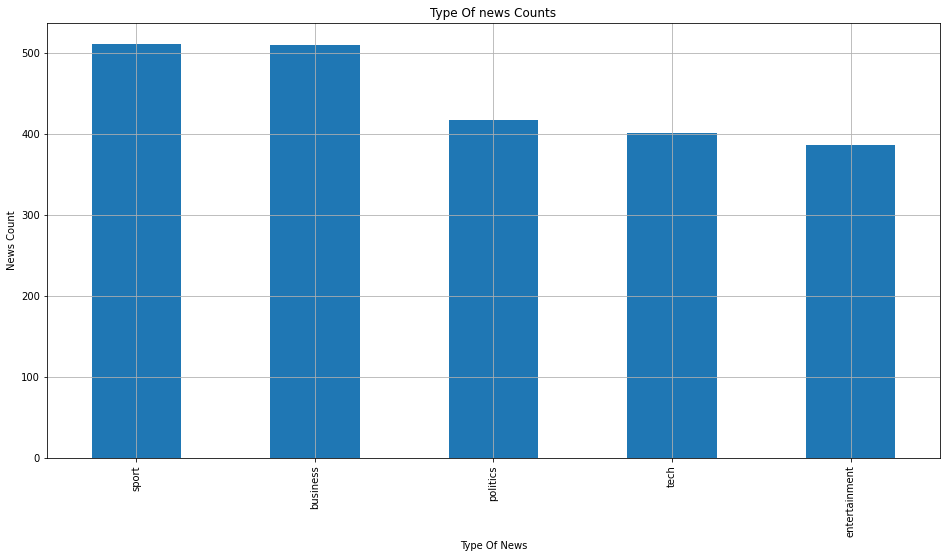

In [ ]:
plt.figure(figsize=(16,8))
df['type'].value_counts().plot(kind='bar',grid=True)
plt.xlabel("Type Of News")
plt.ylabel("News Count")
plt.title("Type Of news Counts")

In [ ]:
df.head()

,news,type
0,b'Mixed signals from French economy\n\nThe Fre...,business
1,b'US trade gap hits record in 2004\n\nThe gap ...,business
2,b'Indonesians face fuel price rise\n\nIndonesi...,business
3,b'High fuel prices hit BA\'s profits\n\nBritis...,business
4,b'Sluggish economy hits German jobs\n\nThe num...,business


In [ ]:
df['news'][0]

b'Mixed signals from French economy\n\nThe French economy picked up speed at the end of 2004, official figures show - but still looks set to have fallen short of the government\'s hopes.\n\nAccording to state statistics body INSEE, growth for the three months to December was a seasonally-adjusted 0.7-0.8%, ahead of the 0.6% forecast. If confirmed, that would be the best quarterly showing since early 2002. It leaves GDP up 2.3% for the full year, but short of the 2.5% which the French government had predicted.\n\nDespite the apparent shortfall in annual economic growth, the good quarterly figures - a so-called "flash estimate" - mark a continuing trend of improving indicators for the health of the French economy. The government is reiterating a 2.5% target for 2005, while the European Central Bank is making positive noises for the 12-nation eurozone as a whole. Also on Friday, France\'s industrial output for December was released, showing 0.7% growth. "The numbers are good," said David 

In [ ]:
df['news'] = df['news'].astype('str') 

In [ ]:
def Change_text(msg):
  punc=[char for char in msg if str(char) not in string.punctuation]
  no_punc=''.join(punc)
  main_text=[word for word in no_punc.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(main_text)

In [ ]:

def lemmatization(texts):
  sentence=''
  allowed_postags=['NOUN','ADJ','VERB','ADV']
  texts_out=[]
  doc=nlp(texts)
  texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return ' '.join(texts_out[0])

In [ ]:
df['news']=df['news'].apply(Change_text)

In [ ]:
nlp=spacy.load('en',disable=['parser', 'ner'])
df['news']=df['news'].apply(lemmatization)

In [ ]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

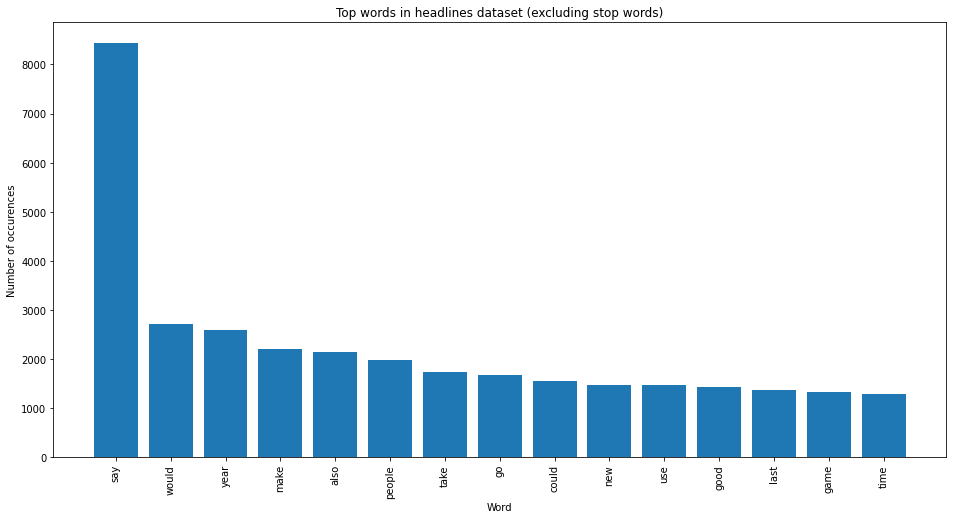

In [ ]:
count_vectorizer = CountVectorizer()
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=df['news'])

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

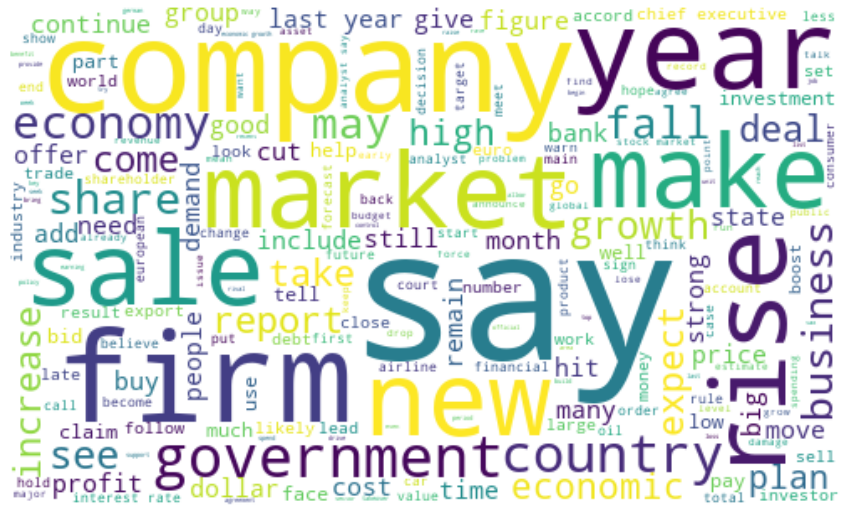

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='business']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

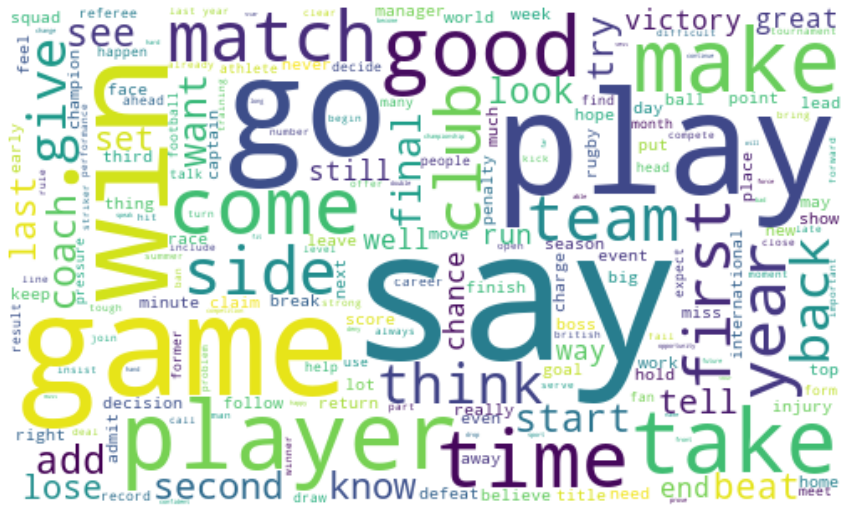

In [ ]:
plt.figure(figsize=(15,10))
allWords = ' '.join([topic for topic in df[df['type']=='sport']['news']])
wordCloud = WordCloud(width=500, height=300, background_color="white", random_state=21, max_font_size=110).generate(allWords)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=5000,min_df=0.05)

In [ ]:
matrix=vectorizer.fit_transform(df['news'])

In [ ]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [ ]:
df1.head()

,able,accept,access,accord,account,accuse,act,action,add,admit,affect,age,ago,agree,ahead,aim,allow,almost,already,also,always,amount,analyst,announce,annual,appear,area,argue,ask,attack,attempt,available,average,avoid,award,away,back,bad,base,battle,...,think,third,time,title,today,together,top,total,tough,trade,trial,try,turn,tv,understand,use,user,value,version,victory,video,view,vote,want,warn,watch,way,website,week,well,whole,win,winner,work,world,would,write,year,yet,young
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.120326,0.0,0.000000,0.0,0.000000,0.057170,0.0,0.0,0.000000,0.0,0.139998,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.087484,0.0,0.0,0.000000,0.139441,0.0,0.0,0.000000,0.000000,0.059653,0.0,0.056768,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106406,0.0,0.0,0.0,0.000000,0.0,0.080934,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.097325,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.065086,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.299886,0.0,0.000000,0.082141,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.064936,0.000000,0.0,0.125160,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.033789,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.078268,0.0,0.000000,0.078539,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.000000,0.043061,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.059917,0.000000,0.0,0.0,0.047901,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.098238,0.000000,0.0,0.000000,0.0,0.0,0.051432,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.067102,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.083273,0.0,0.000000,0.0,0.000000,0.039565,0.0,0.0,0.161593,0.0,0.096887,0.0,0.0,0.000000,0.0,0.087986,0.000000,0.0,0.100422,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.075622,0.000000,0.0,0.0,0.0,0.000000,0.091025,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084549,0.0,0.060544,0.0,0.0,0.060224,0.000000,0.0,0.0,0.000000,0.000000,0.041283,0.0,0.157147,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105586,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.074074,0.041692,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.064585,0.0,0.0,0.0,...,0.0,0.079687,0.000000,0.0,0.0,0.0,0.149446,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.122345,0.000000,0.000000,0.0,0.041398,0.0,0.0


In [ ]:
model=LatentDirichletAllocation(n_components=5)
model.fit(matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      150.222153  -72.269554       1        1  43.028886
4       51.163364 -159.968018       2        1  22.864194
1      -73.144554   21.523815       3        1  19.605893
2      -66.410133 -110.606438       4        1  10.930907
3       54.417324   12.443444       5        1   3.570120, topic_info=        Term       Freq      Total Category  logprob  loglift
158     film  84.000000  84.000000  Default  30.0000  30.0000
403    share  49.000000  49.000000  Default  29.0000  29.0000
46       bid  38.000000  38.000000  Default  28.0000  28.0000
302    offer  48.000000  48.000000  Default  27.0000  27.0000
107     deal  45.000000  45.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
74     chief   2.504002  31.189964   Topic5  -5.2444   0.8104
188    group   2.991628  38.287254   Topic5  -5.0665   0.7833
211  include   3.877436  57.924110   Topic5  -4.8072   0.6286
206  however   2.146338  30.798238   Topic5  -5.3986   0.6689
19      also   2.300018  85.726030   Topic5  -5.3294  -0.2857

[248 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2         1  0.316392  access
2         3  0.685516  access
5         1  0.864681  accuse
5         2  0.057645  accuse
5         3  0.057645  accuse
...     ...       ...     ...
485       1  0.470412    year
485       2  0.196005    year
485       3  0.127403    year
485       4  0.196005    year
485       5  0.009800    year

[647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 4])

In [ ]:
df['length']=df['news'].apply(len)

In [ ]:
df.head(15)

,news,type,length
0,bmixe signal french economynnthe french econom...,business,707
1,gap hit record gap export import hit late figu...,business,1082
2,bindonesian face fuel price government confirm...,business,893
3,bhigh fuel price hit ba profitsnnbritish blame...,business,1313
4,bsluggish economy hit german number people wor...,business,1140
5,bair passenger win new passenger unable board ...,business,1985
6,user lose patiencenncustomer try call centre g...,business,2044
7,alert recall world big carmaker recall nearly ...,business,894
8,rupee hit rupee hit fiveyear high raise countr...,business,434
9,unit buyer face loan owner embattle russian oi...,business,807


In [ ]:
business = df[df['type'] == 'business']
entertainment = df[df['type'] == 'entertainment']
politics = df[df['type'] == 'politics']
sport = df[df['type'] == 'sport']
tech = df[df['type'] == 'tech']


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

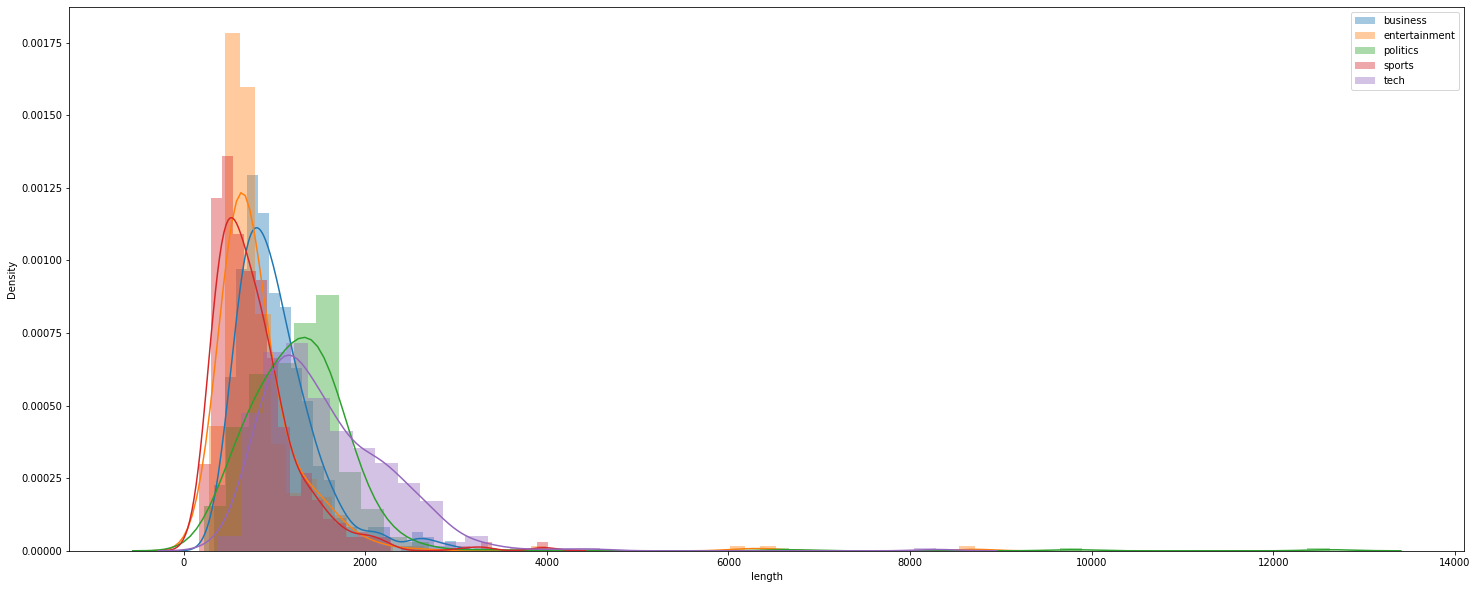

In [ ]:
fig = plt.figure(figsize=(25,10))
sns.distplot(df.loc[df['type'] == 'business', 'length'],label='business')
sns.distplot(df.loc[df['type'] == 'entertainment', 'length'],label='entertainment')
sns.distplot(df.loc[df['type'] == 'politics', 'length'],label='politics')
sns.distplot(df.loc[df['type'] == 'sport', 'length'],label='sports')
sns.distplot(df.loc[df['type'] == 'tech', 'length'],label='tech')

plt.legend()
plt.show()

In [ ]:
word_data=df['news'].str.split().tolist()

In [ ]:
id2word=corpora.Dictionary(word_data)
corpus=[id2word.doc2bow(text) for text in word_data]

In [ ]:
print(corpus[2])

[(3, 1), (9, 1), (26, 1), (27, 6), (30, 1), (36, 1), (54, 4), (60, 1), (65, 1), (67, 1), (74, 2), (82, 1), (103, 2), (124, 1), (128, 1), (131, 1), (133, 1), (138, 1), (141, 1), (146, 1), (147, 10), (149, 1), (158, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 2), (179, 1), (180, 1), (181, 1), (182, 2), (183, 1), (184, 1), (185, 1), (186, 1), (187, 3), (188, 1), (189, 1), (190, 1), (191, 1), (192, 2), (193, 1), (194, 1), (195, 1), (196, 2), (197, 7), (198, 1), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 1), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 2), (216, 1), (217, 1), (218, 1), (219, 1), (220, 2), (221, 1), (222, 3), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 2), (229, 1), (230, 1), (231, 1), (232, 1), (233, 6), (234, 1), (235, 1), (236, 1), (237, 1), (238, 1), (239, 1), (240, 1), (241, 2), (242, 1)]


In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('10n', 1),
  ('activity', 1),
  ('ahead', 1),
  ('also', 1),
  ('annual', 1),
  ('apparent', 1),
  ('best', 1),
  ('bmixe', 1),
  ('body', 1),
  ('confirm', 1),
  ('continuation', 1),
  ('continue', 1),
  ('early', 1),
  ('economic', 1),
  ('economist', 1),
  ('economy', 2),
  ('economynnthe', 1),
  ('end', 1),
  ('estimate', 1),
  ('eurozone', 1),
  ('fall', 1),
  ('figure', 2),
  ('flash', 1),
  ('forecast', 1),
  ('french', 4),
  ('full', 1),
  ('good', 2),
  ('government', 3),
  ('growth', 3),
  ('health', 1),
  ('high', 2),
  ('hit', 1),
  ('hopesnnaccorde', 1),
  ('improve', 2),
  ('indicator', 1),
  ('industrial', 1),
  ('leave', 1),
  ('look', 1),
  ('make', 1),
  ('mark', 1),
  ('month', 1),
  ('noise', 1),
  ('number', 1),
  ('official', 1),
  ('open', 1),
  ('output', 2),
  ('pick', 1),
  ('positive', 2),
  ('predictednndespite', 1),
  ('quarterly', 2),
  ('rebound', 1),
  ('reiterate', 1),
  ('release', 1),
  ('remain', 1),
  ('say', 1),
  ('seasonallyadjuste', 1),
  ('s

In [ ]:
import gensim

In [ ]:
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=5,update_every=1)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [ ]:
import pyLDAvis.gensim

In [ ]:
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model,corpus,id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.001966 -0.047131       1        1  34.218012
3      0.042318 -0.017944       2        1  26.880691
2     -0.048956 -0.002568       3        1  17.358468
4      0.042976  0.040814       4        1  14.016745
0     -0.038304  0.026830       5        1   7.526084, topic_info=            Term         Freq        Total Category  logprob  loglift
240          use  2206.000000  2206.000000  Default  30.0000  30.0000
54           say  7355.000000  7355.000000  Default  29.0000  29.0000
506   technology  1388.000000  1388.000000  Default  28.0000  28.0000
575       mobile   991.000000   991.000000  Default  27.0000  27.0000
1220        game  2215.000000  2215.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
325         take    94.796366  1244.259747   Topic5  -5.6305   0.0122
74          year   107.301104  2308.409022   Topic5  -5.5066  -0.4819
575       mobile    87.339706   991.690669   Topic5  -5.7124   0.1572
1220        game    93.162231  2215.729810   Topic5  -5.6479  -0.5822
590        phone    83.219889   981.285325   Topic5  -5.7607   0.1194

[472 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
638        1  0.893475   2005n
638        3  0.092428   2005n
18597      1  0.975118  3dlike
19893      1  0.189547     GHz
19893      2  0.189547     GHz
...      ...       ...     ...
74         1  0.527636    year
74         2  0.201437    year
74         3  0.141656    year
74         4  0.082741    year
74         5  0.046352    year

[1276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 5, 1])

In [ ]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topic_matrix = lsa_model.fit_transform(matrix)

In [ ]:
from collections import Counter
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [ ]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [ ]:
print(lsa_categories, lsa_counts)

[0, 4, 2, 1, 3] [1883, 81, 129, 47, 85]
